# Naive method
In this notebook we obtain the $e^+e^-\rightarrow\eta\pi^+\pi^-$ Born cross section using the naive method. Visible cross section data is generated using the model Born crosection. Here we consider only a relatively simple model $\rho(770),\,\rho(1450)\rightarrow\eta\rho(770)$. The statistical uncertainties of the generated visible cross section are proportional to the square roots of the cross section values. In this notebook, the following parameters are constant:
- $50$ equidistant c.m. energy points, 
- $\varepsilon(x,s)=1$,
- piecewise linear interpolation of unknown values of the Born section is used.

In [1]:
import numpy as np
import json
import seaborn as sns
from PyISR import ISRSolverSLE
from ROOT import TFile
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                                          'Lucida Grande', 'Verdana']

Welcome to JupyROOT 6.24/02


Remove scrolling:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

Saving the current Matplotlib style:

In [4]:
# Current Matplotlib style parameters
mplStyleParams = dict(matplotlib.rcParams)
# Deprecated parameters
deprecatedParams = ['animation.avconv_args', 'animation.avconv_path', 
                    'animation.html_args', 'keymap.all_axes',
                   'savefig.jpeg_quality', 'text.latex.preview']
# Remove deprecated parameters in oder to avoid warnings
_ = list(map(lambda key : mplStyleParams.pop(key, None), deprecatedParams))

Function for reading visible cross section data:

In [5]:
def readVCS(path):
    fl = TFile.Open(path, "read")
    # Getting a pointer to the visible cross section in the form of TGraphErrors
    gvcs = fl.Get('vcs')
    # Number of c.m. energy points
    n = gvcs.GetN()
    # Reading c.m. energy array
    energy = np.frombuffer(gvcs.GetX(), dtype=np.float64, count=n)
    # Reading array of c.m. energy errors
    energyErr = np.frombuffer(gvcs.GetEX(), dtype=np.float64, count=n)
    # Reading visible cross section array
    vcs = np.frombuffer(gvcs.GetY(), dtype=np.float64, count=n)
    # Reading array of visible cross section errors
    vcsErr = np.frombuffer(gvcs.GetEY(), dtype=np.float64, count=n)
    fl.Close()
    return energy, vcs, energyErr, vcsErr

Function for obtaining numerical solution:

In [6]:
def solve(energy, vcs, energyErr, vcsErr, 
          enabled_energy_spread=False, 
          threshold_energy=0.827, 
          interp_path=None,
          efficiency=lambda x, en: 1.0):
    n = energy.shape[0]
    solver = ISRSolverSLE(n, energy, vcs, 
                          energyErr, vcsErr, 
                          threshold_energy, efficiency,
                          enabled_energy_spread)
    if type(interp_path) == str:
        with open(interp_path, 'r') as jfl:
            settings = json.load(jfl)
            
        solver.set_interp_settings(settings)
    
    solver.solve()
    return solver

Function for cross section plotting:

In [7]:
def csPlot(solver, title='Cross sections', fontsize=24):
    # Getting c.m. energy array
    ecm = solver.ecm()
    matplotlib.rcParams.update(mplStyleParams)
    f, ax = plt.subplots(figsize=(9, 7))
    f.suptitle(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.errorbar(ecm, solver.vcs(), 
                xerr=solver.ecm_err(),
                yerr=solver.vcs_err(), fmt='o', 
                label='Visible cross section', zorder=0)
    ax.errorbar(ecm, solver.bcs(), yerr=np.sqrt(np.diag(solver.bcs_cov_matrix())), fmt='o', 
                label='Born cross section', zorder=1)
    ax.set_xlabel(r'$\sqrt{s}$ (GeV)', fontsize=fontsize)
    ax.set_ylabel('cross section (nb)', fontsize=fontsize)
    ax.legend(fontsize=24)

Function for plotting matrices:

In [8]:
def matrixPlot(mx, title='', fontsize=24, fontscale=2.0):
    sns.set(font_scale=fontscale)
    f, ax = plt.subplots(figsize=(9, 7))
    f.suptitle(title, fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    sns.heatmap(mx, ax=ax, square=True)

## No c.m. energy spread: $\sigma_E(s)=0$ MeV

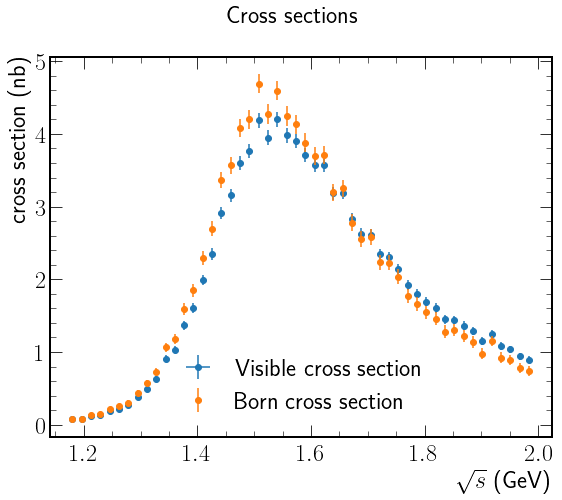

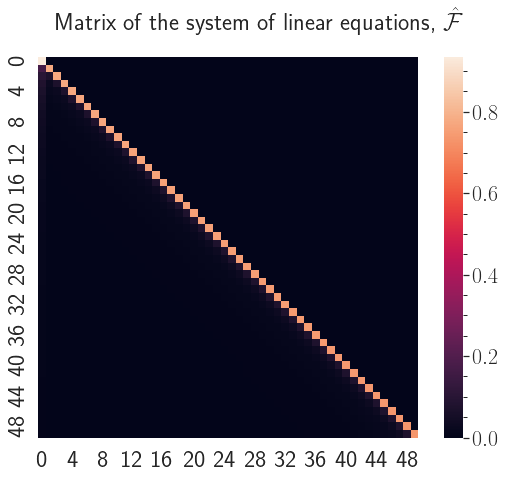

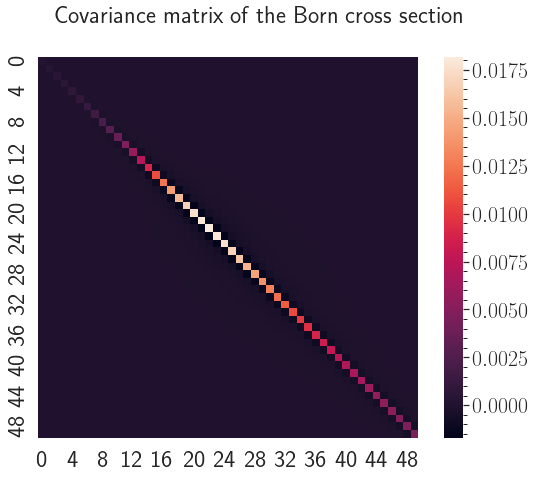

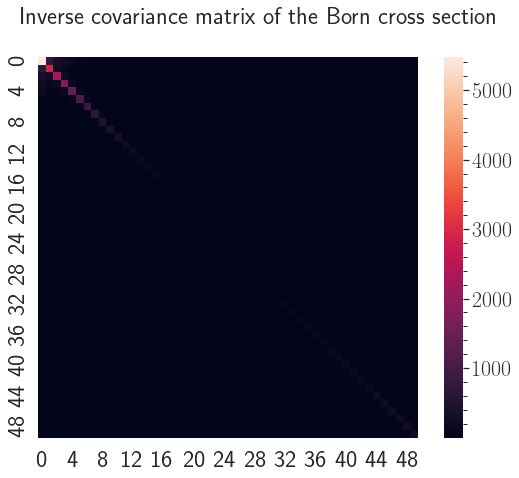

In [9]:
input_path = 'gen_visible_cs_etapipi_simple_model_no_energy_spread.root'
solver = solve(*readVCS(input_path))
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')
matrixPlot(solver.bcs_inv_cov_matrix(), title=r'Inverse covariance matrix of the Born cross section')

## $\sigma_E(s)=2$ MeV

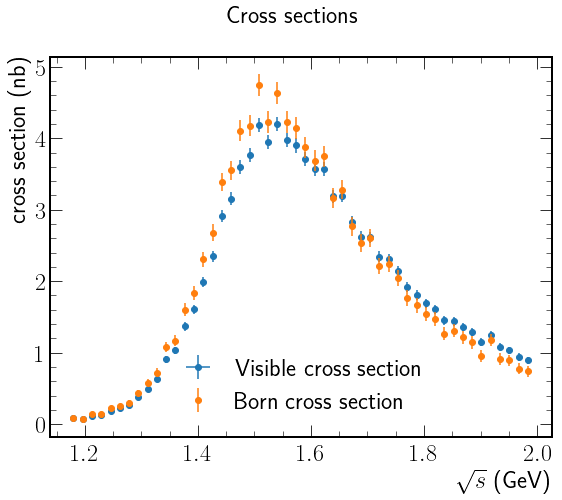

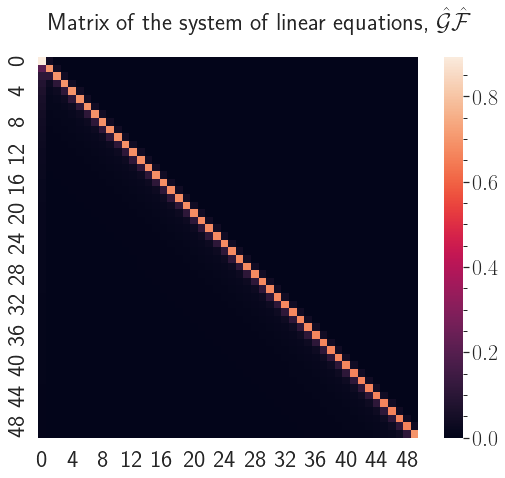

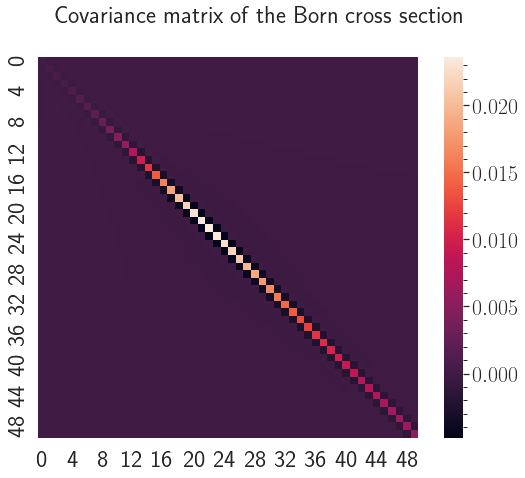

In [10]:
input_path = 'gen_visible_cs_etapipi_simple_model_energy_spread_2MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E(s)=5$ MeV

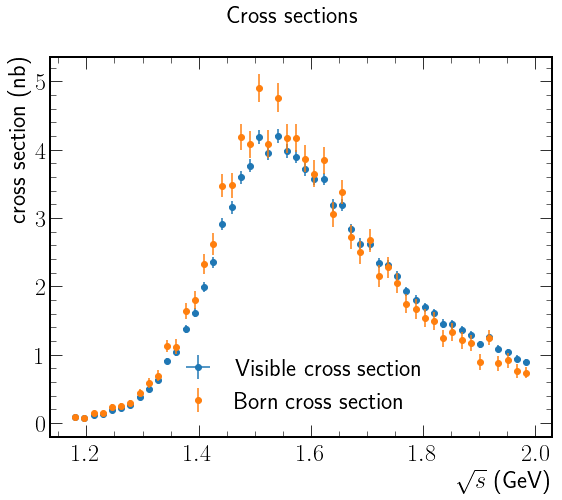

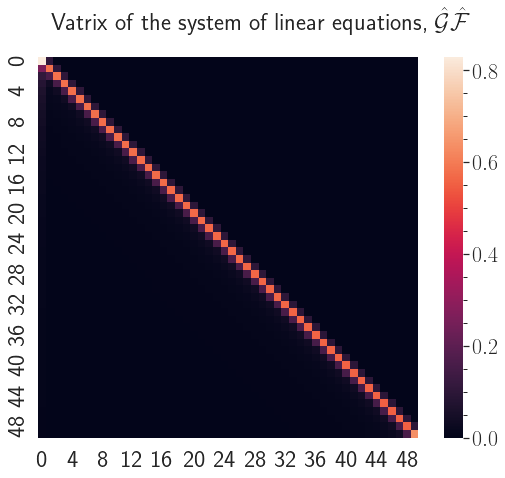

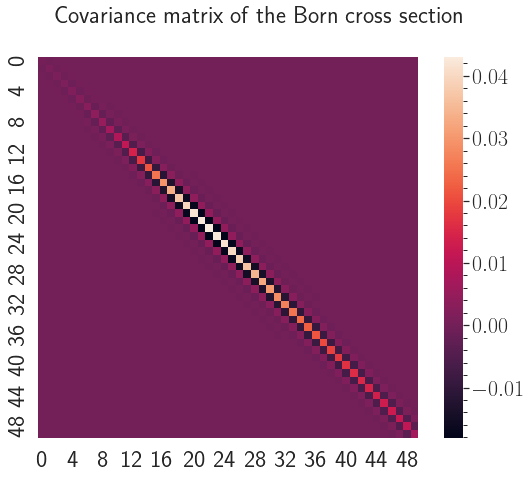

In [11]:
input_path = 'gen_visible_cs_etapipi_simple_model_energy_spread_5MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Vatrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E(s) = 10$ MeV

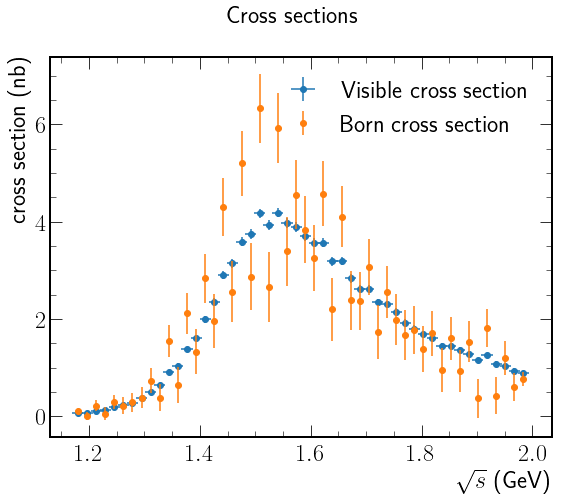

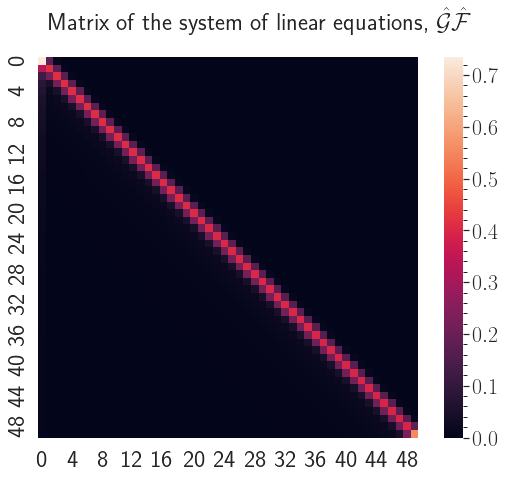

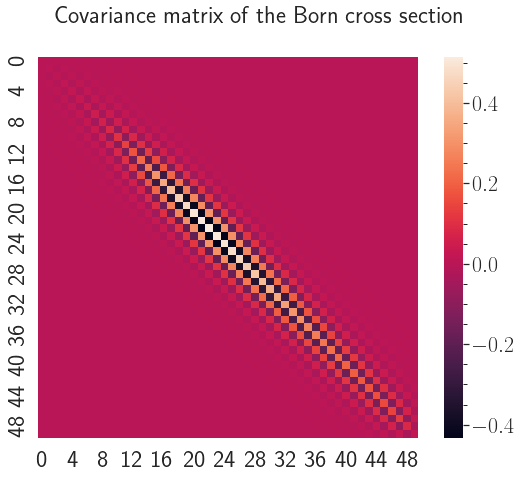

In [12]:
input_path = 'gen_visible_cs_etapipi_simple_model_energy_spread_10MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title=r'Covariance matrix of the Born cross section')

## $\sigma_E(s) = 20$ MeV

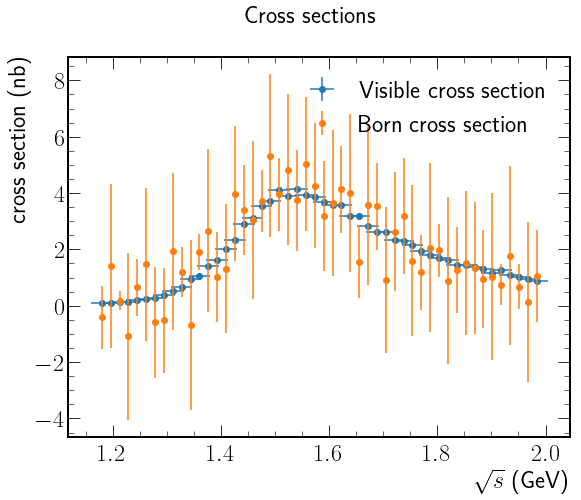

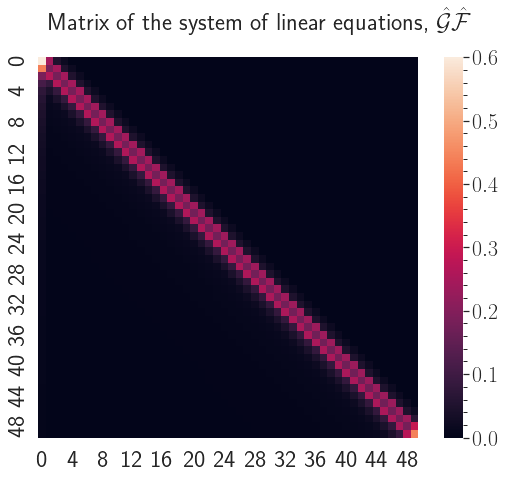

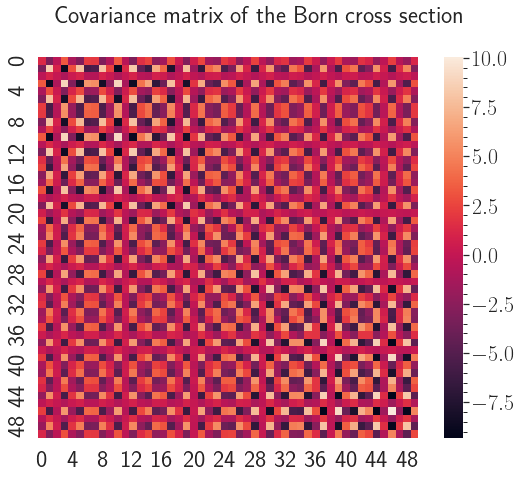

In [13]:
input_path = 'gen_visible_cs_etapipi_simple_model_energy_spread_20MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title='Covariance matrix of the Born cross section')

## $\sigma_E(s)=50$ MeV

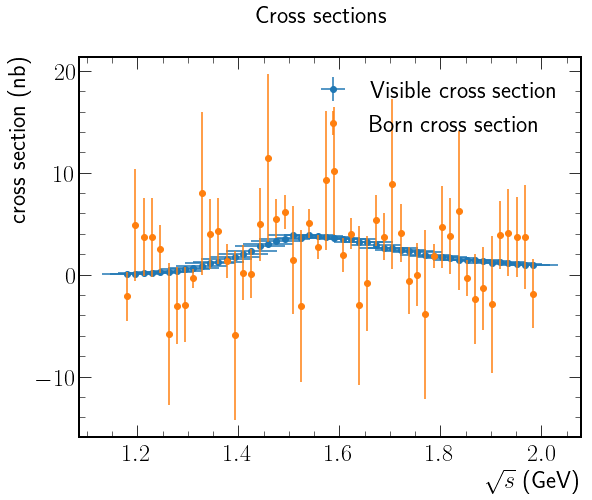

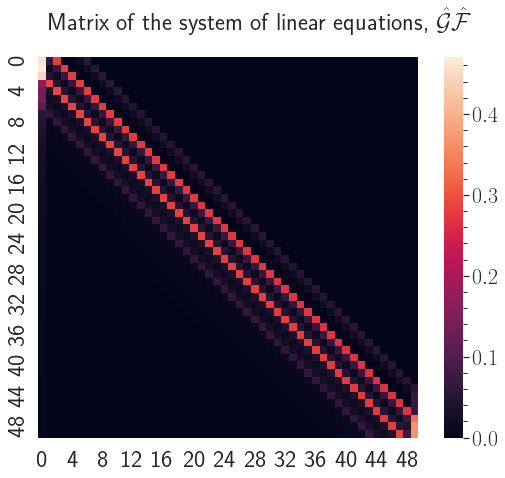

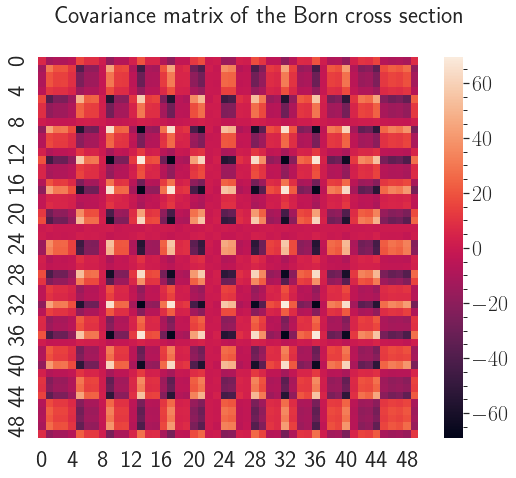

In [14]:
input_path = 'gen_visible_cs_etapipi_simple_model_energy_spread_50MeV.root'
solver = solve(*readVCS(input_path), enabled_energy_spread=True)
csPlot(solver)
matrixPlot(solver.intop_matrix(), title=r'Matrix of the system of linear equations, $\hat{\mathcal{G}}\hat{\mathcal{F}}$')
matrixPlot(solver.bcs_cov_matrix(), title='Covariance matrix of the Born cross section')